TODO:
- run models again on new OSM cubes
- try not predicting on the entire OSM grid, not just the aggregated OSM

In [1]:
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import omegaconf
import hydra

from sklearn.metrics import precision_score, recall_score
from loguru import logger
from omegaconf import DictConfig, OmegaConf
from progressbar import progressbar as pbar
from earthtext.models.multilabel import ContextualCNN, MultisizeContextualCNN, MultiscaleContextualCNN
from earthtext.osm import multilabel

%load_ext autoreload
%autoreload 2


name_dict = multilabel.OSMCodeSets.get('naip')['kvmerged'].inverse_codes
tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'prec': prec(y_true, y_pred)}

# Train on all OSM classes

In [8]:
conf = OmegaConf.load("../../configs/naip-multilabel-contextual.yaml")
# conf = OmegaConf.load("../../configs/naip-multilabel.yaml")
dl = hydra.utils.instantiate(conf.dataloader)

2024-06-20 07:19:35.501 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:105 - using embeddings found in metadata file
2024-06-20 07:19:35.503 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:118 - read train split with 72268 chip files (out of 72268)
2024-06-20 07:19:35.503 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:122 - removing chip IDs with no associated neighbors .npy files
2024-06-20 07:19:36.309 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:132 - max cache size is -1
2024-06-20 07:19:37.669 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:105 - using embeddings found in metadata file
2024-06-20 07:19:37.672 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:118 - read val split with 14770 chip files (out of 14770)
2024-06-20 07:19:37.672 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:122 - removing chip IDs with no associate

In [9]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)

print(sum([np.product(p.shape) for p in m.parameters()]))

2987532


In [10]:
print(dltrain.dataset.embeddings_normalization)
print(dltrain.dataset.osmvector_normalization)

True
False


In [12]:
m.to('cuda');  # move to GPU
print(next(m.parameters()).is_cuda)

True


In [13]:
# Example usage

# Define input tensor size
R = conf.dataloader.neighborhood_radius
H, W, C = 2*R + 1, 2*R + 1, 768  # Example input tensor shape
input_tensor = torch.randn(5, C, H, W)  # Example input tensor

# Create CNN model for multi-label classification
# cnn_model = ContextualCNN(input_dim=C, output_dim=140, layers_spec = [512, 256, 128], channel_specific=True)
cnn_model = MultiscaleContextualCNN(input_dim=C, output_dim=140, layers_spec = [512, 256, 128])

output = cnn_model(input_tensor)
print(output.shape)

torch.Size([5, 140])


In [14]:
# dl.train_dataset[0]['embedding'].float().dtype
# batch = next(iter(dl.train_dataloader()))
# batch['embedding'].to(device).float().dtype
# batch['embedding'].dtype
# batch['embedding'].to(device).dtype

In [15]:
n_epochs = 2

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding'].to('cuda').float()
        t = batch['multilabel'].to('cuda').float()

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 4516 loss 0.15839 params 0.0781006
epoch   1 step 4516 loss 0.15030 params 0.1012600


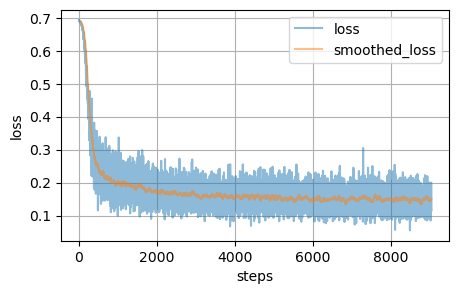

In [17]:
# R=8 CNN multi-scale aggregated labels of 17x17 grid
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(5,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");
# plt.yscale('log');

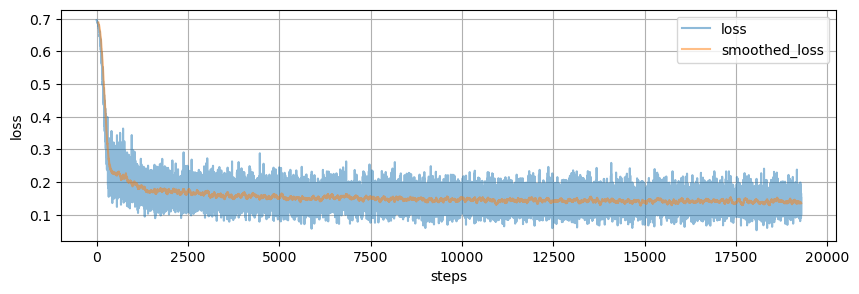

In [29]:
# R=8 CNN multi-size aggregated labels of 17x17 grid

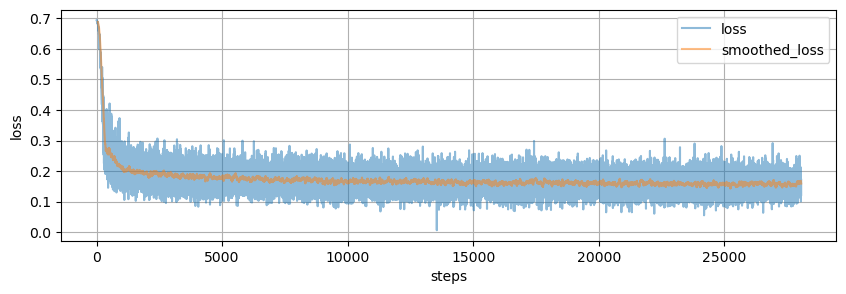

In [15]:
# R=8 CNN multi-size aggregated labels of circle grid

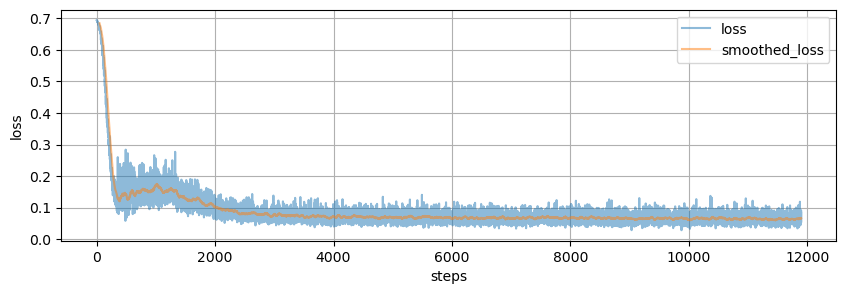

In [13]:
# R=8 CNN multi-size

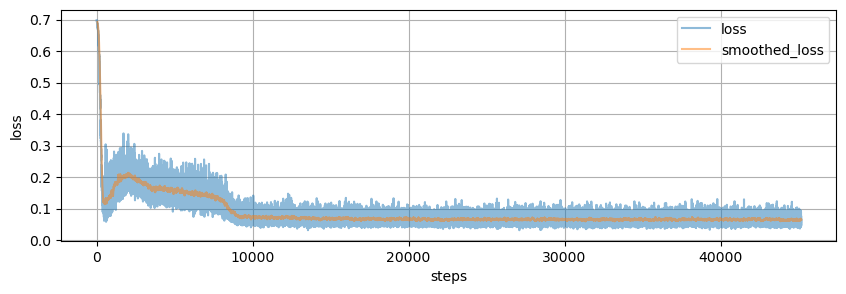

In [10]:
# R=8 CNN channel specific

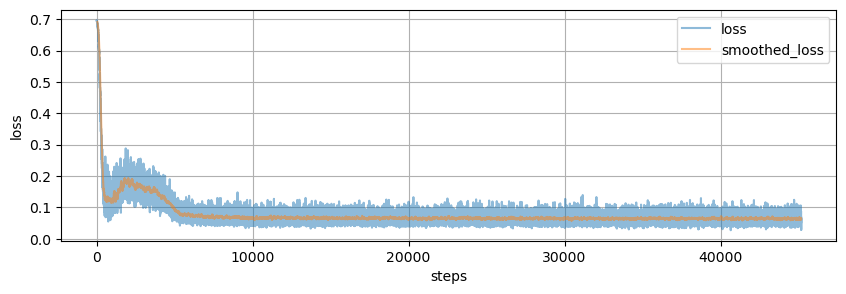

In [12]:
# R=8

In [20]:
dltrain.dataset

ChipMultilabelDataset train split with 72258 items, in cache 1 items

In [21]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding'].to('cuda').float()
    t = batch['multilabel'].to('cuda').float()

    o = m(x)

    for ti in t.detach().cpu().numpy():
        targets.append(ti)

    for oi in o.detach().cpu().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (4517 of 4517) |####################| Elapsed Time: 0:13:02 Time:  0:13:020603


((72258, 140), (72258, 140))

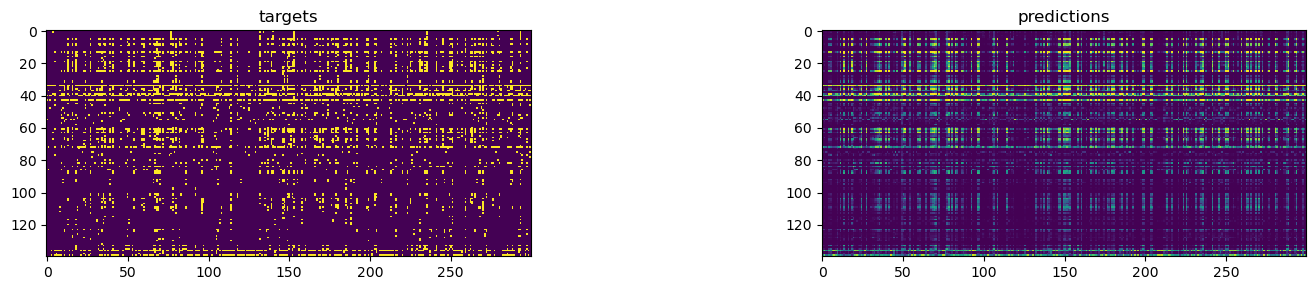

In [22]:
idxs = np.random.permutation(len(targets))[:300]

for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [23]:
metr(targets.flatten(), predictions.flatten()>.5)  # R=8 CNN multi-scale aggregated labels 17x17

{'tpr': 0.5538678182100942, 'prec': 0.7466445723705466}

In [36]:
# R=8 CNN multi-size aggregated labels 17x17

{'tpr': 0.5659076819507498, 'prec': 0.769373246810045}

In [19]:
# R=8 CNN multi-size aggregated labels

{'tpr': 0.6384715096705353, 'prec': 0.7923195834020881}

In [13]:
# R=8 CNN multi-size

{'tpr': 0.3422574167114158, 'prec': 0.6674580574822295}

In [13]:
# R=8 CNN channel specific

{'tpr': 0.2919348550495428, 'prec': 0.6628779021212627}

In [42]:
# R=8 CNN

{'tpr': 0.24054199186423722, 'prec': 0.6922466260915586}

In [16]:
# R=8 avg

{'tpr': 0.29163693606879354, 'prec': 0.6930513067039594}

In [15]:
# R=3 avg

{'tpr': 0.2517341827089295, 'prec': 0.6984692315542402}

In [20]:
# R=0

{'tpr': 0.24537397955431345, 'prec': 0.692562378046249}

In [13]:
# metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.3117578828485089, 'prec': 0.6200271156258853}

In [37]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


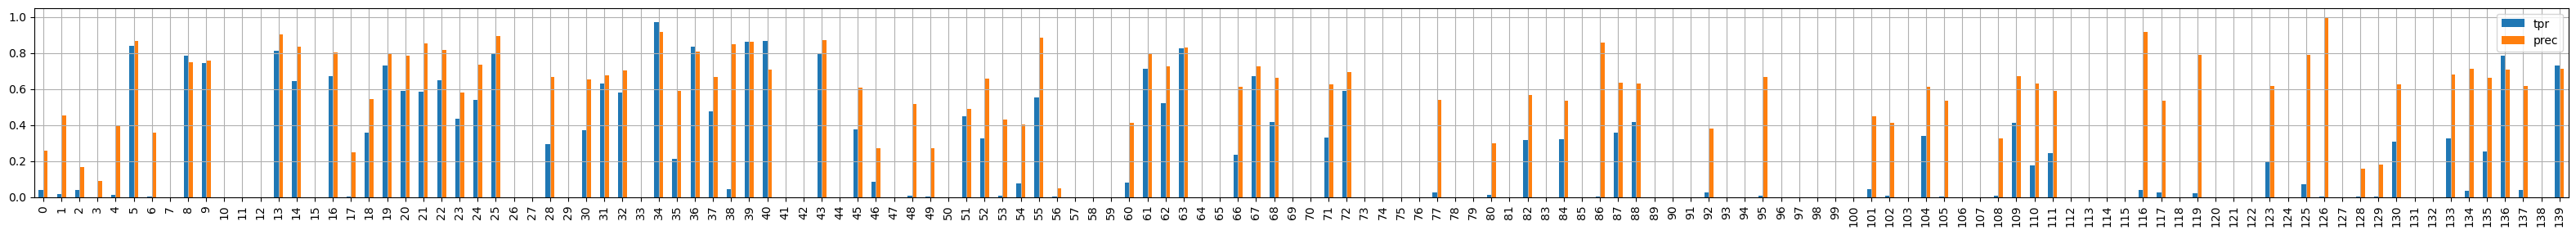

In [38]:
ax = r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()

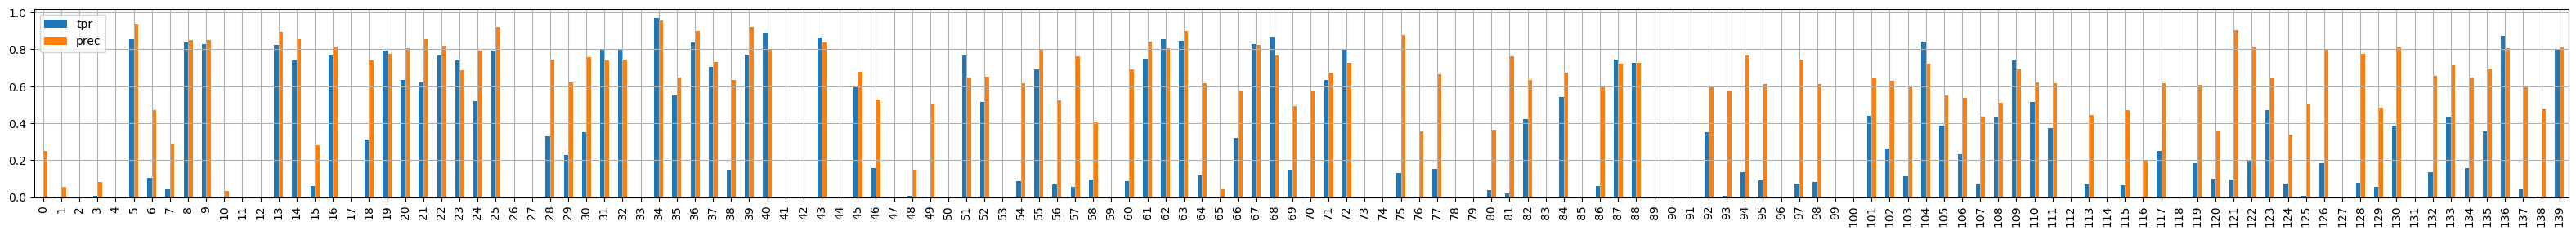

In [21]:
# aggregated labels

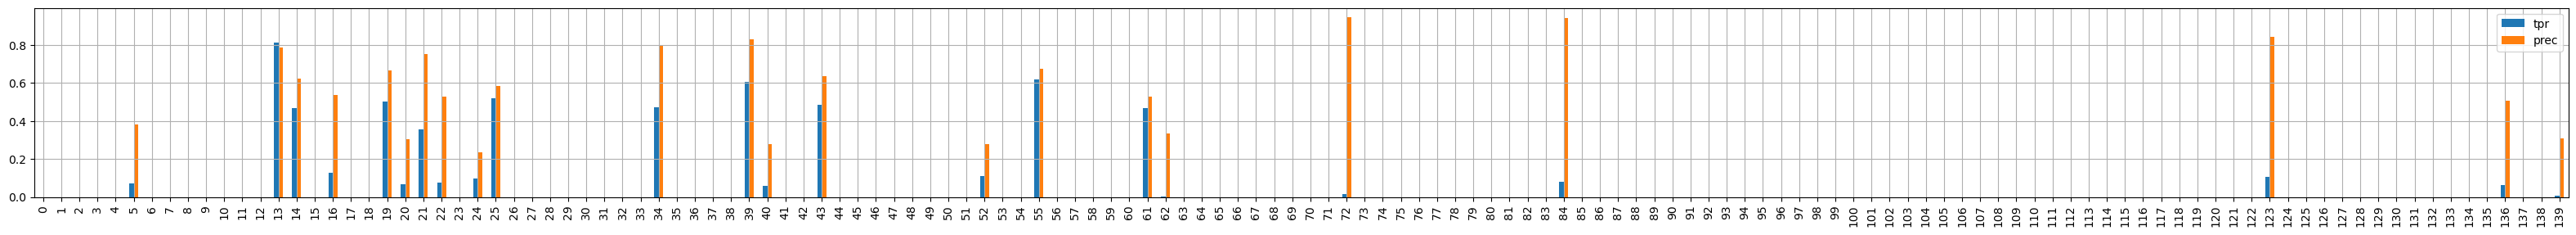

In [18]:
# R=8

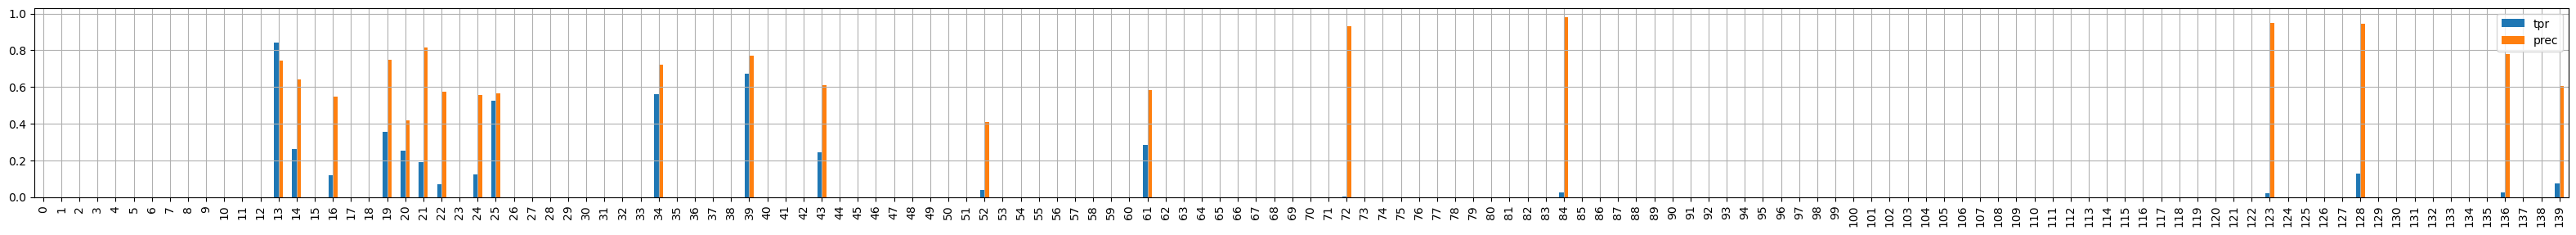

In [17]:
# R=3

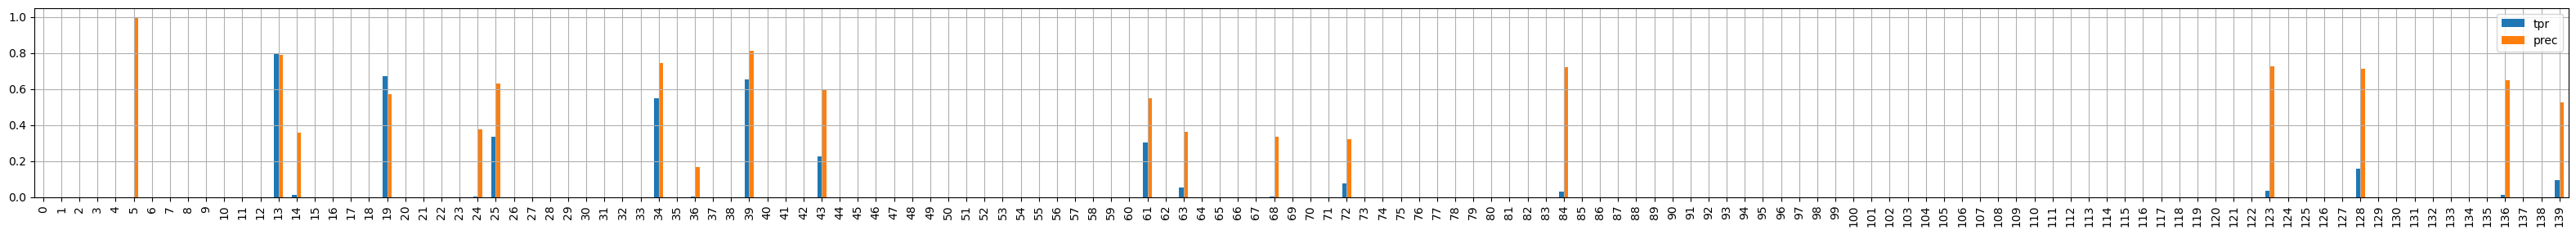

In [39]:
# R=0

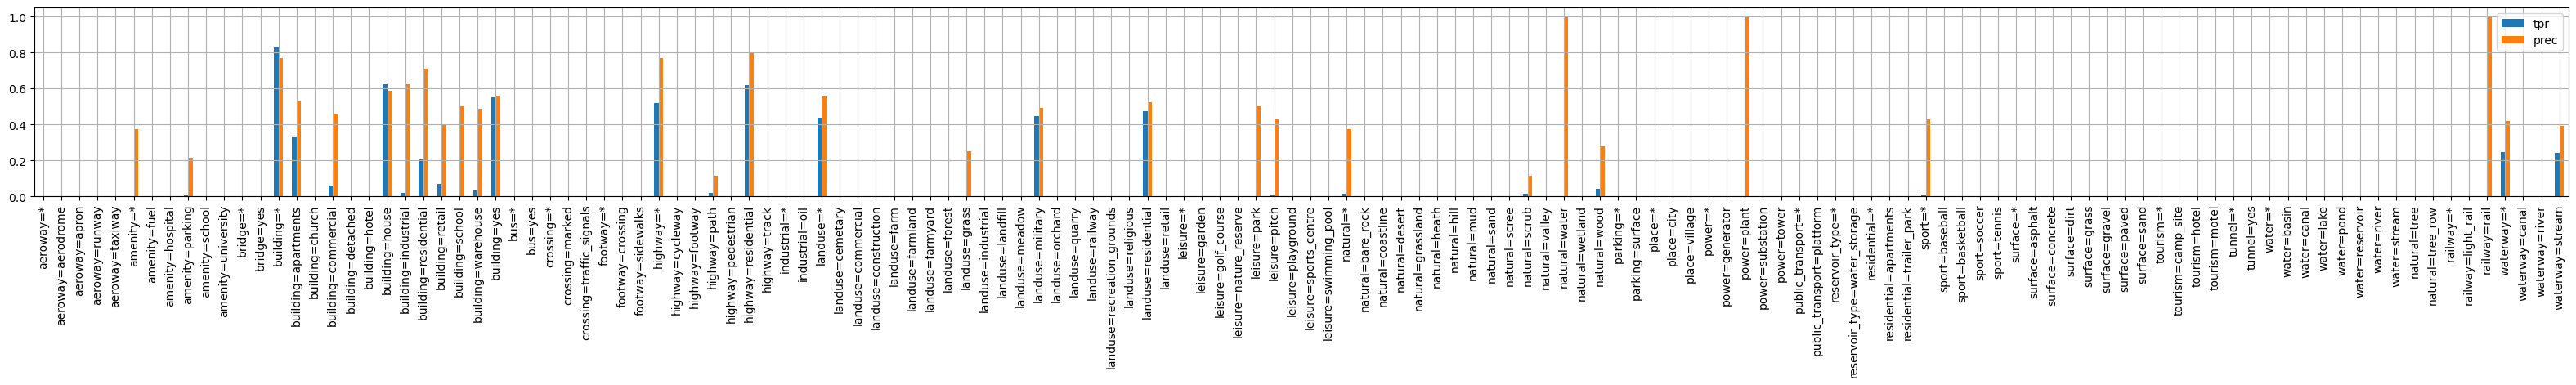

In [15]:
ax = r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()
ax.set_xticklabels(labels=(name_dict[i] for i in range(targets.shape[-1])), rotation=90, fontsize=10);

In [16]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100% (100 of 100) |######################| Elapsed Time: 0:03:58 Time:  0:03:580221


(100, 140, 2)

In [17]:
classes_retain = list(range(140))

# print(len(classes_retain))
# for c in classes_retain:
#     print(c, name_dict[c])

<Figure size 640x480 with 0 Axes>

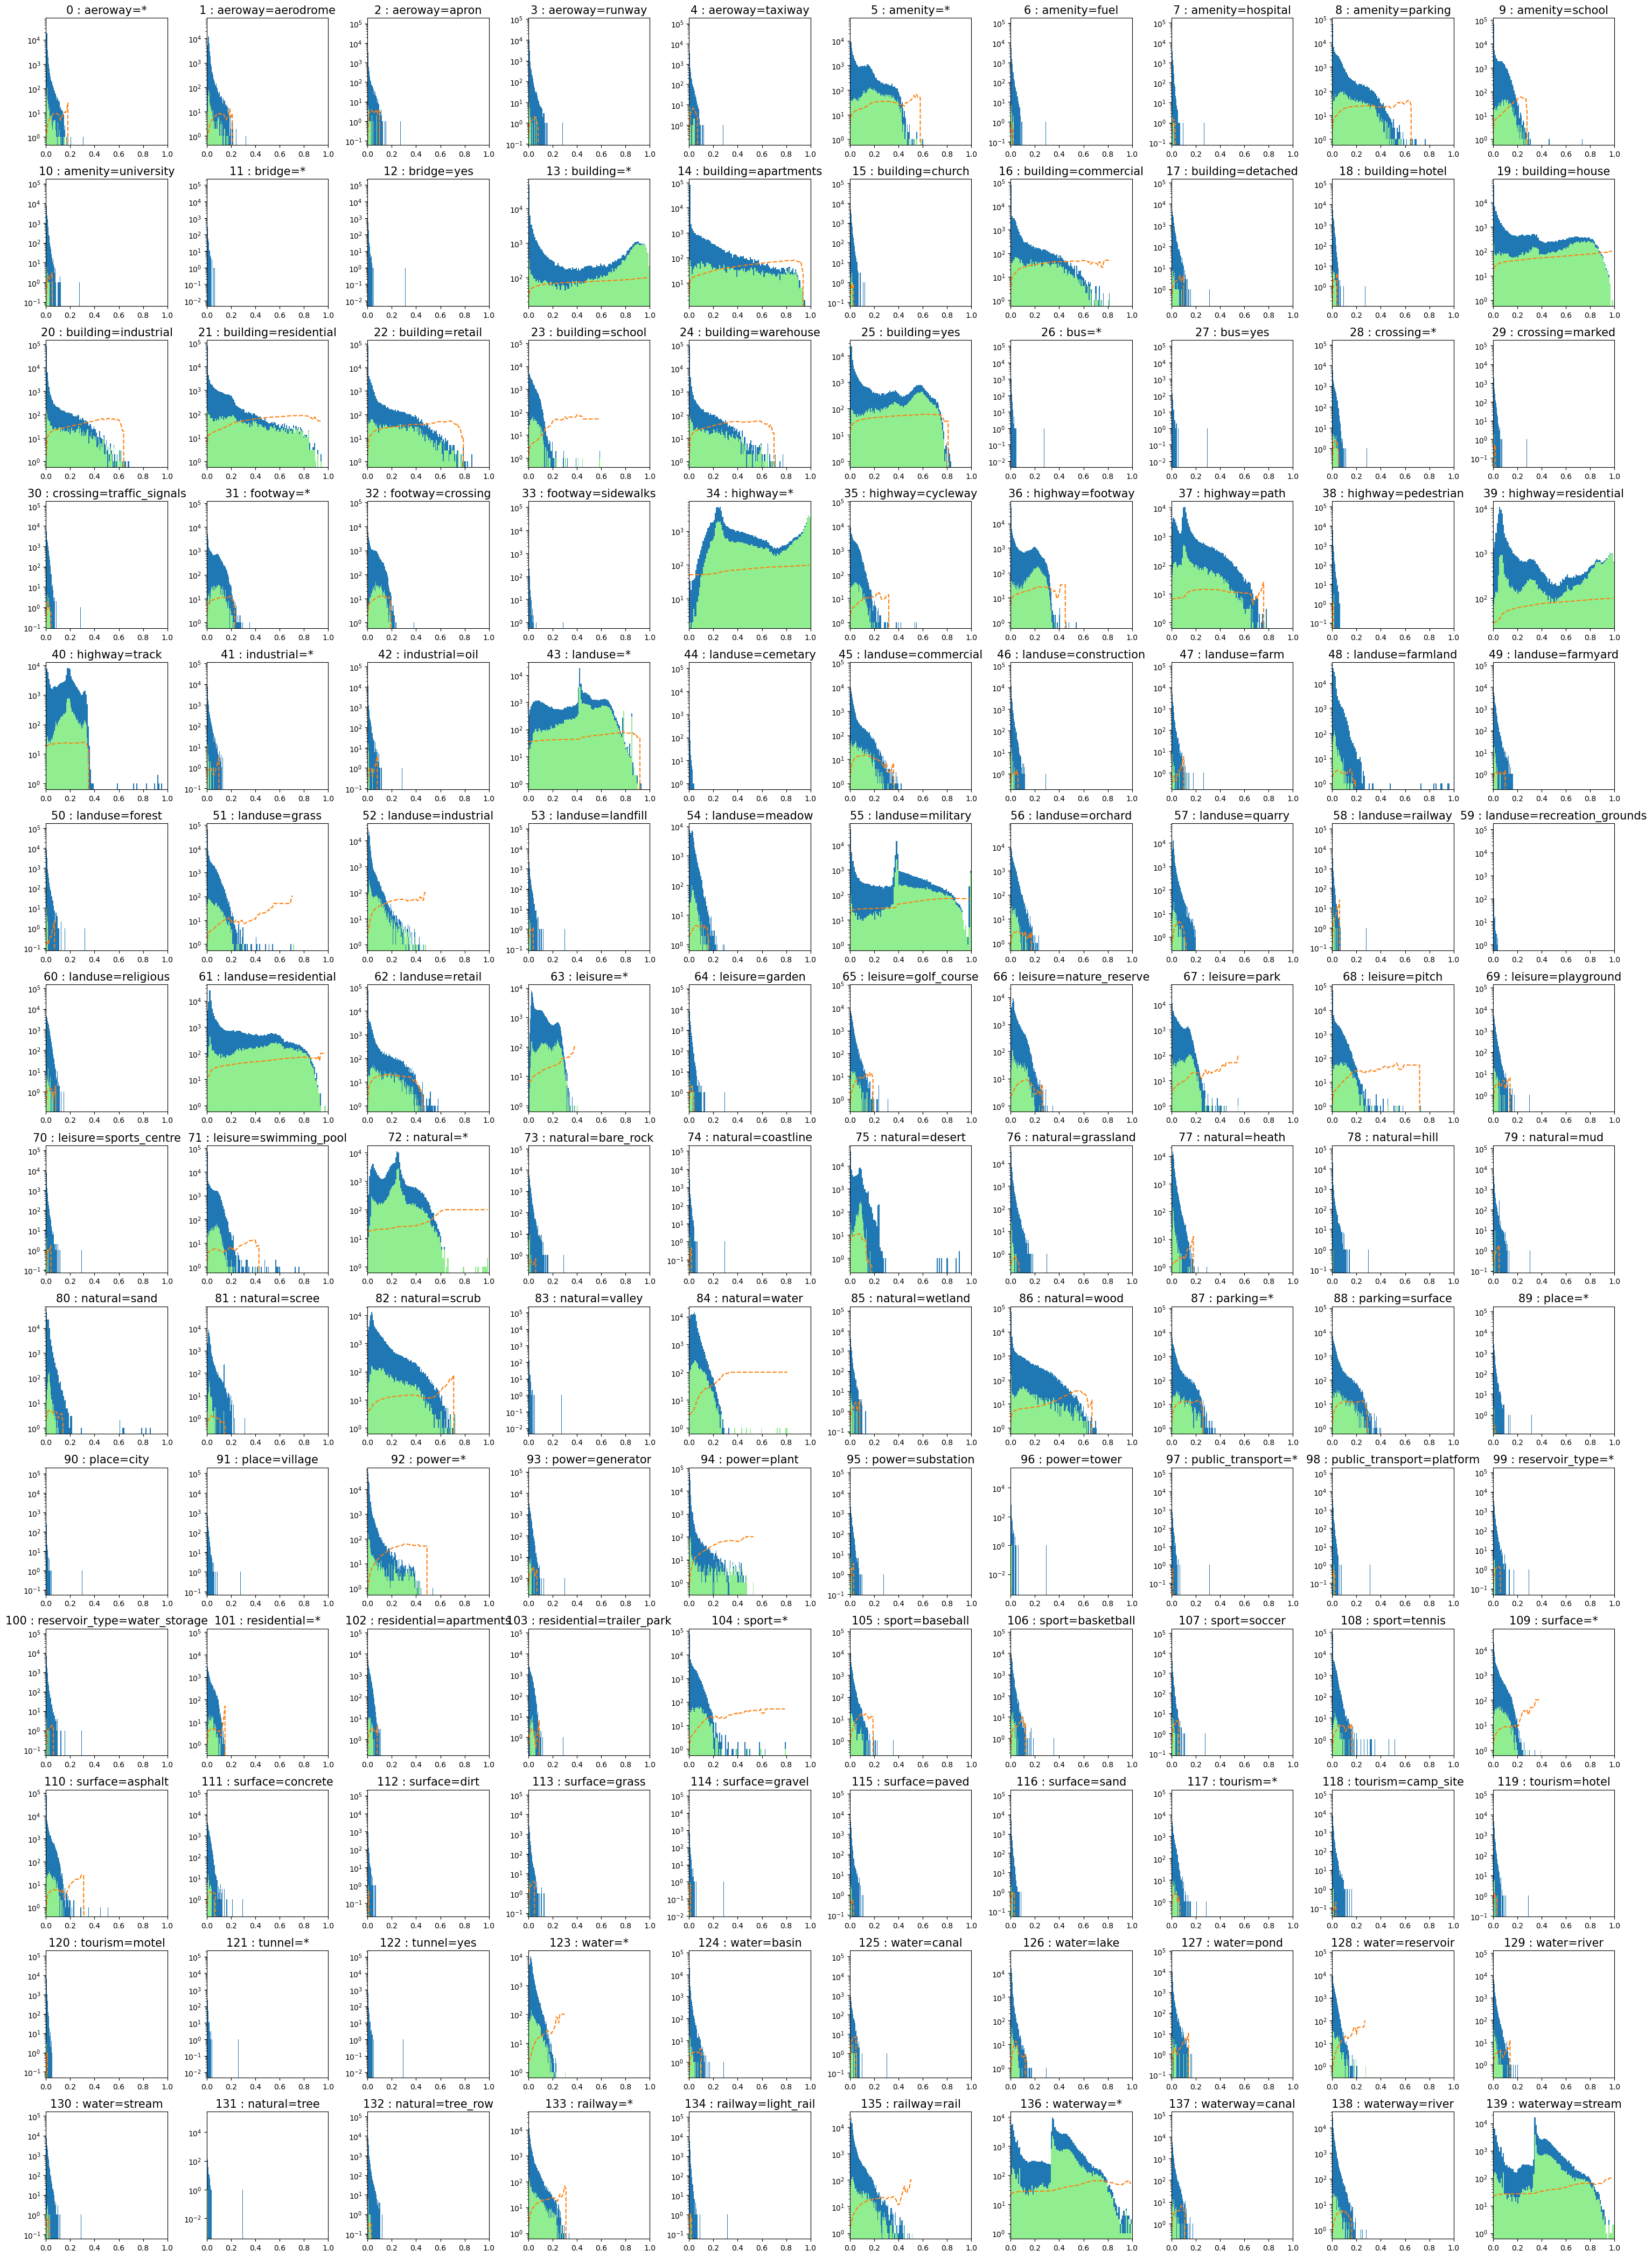

In [18]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    if c in classes_retain:
        plt.hist(predictions[:, c], bins=100);
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
    else:
        plt.hist(predictions[:, c], bins=100, color='black');
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='gray');
    plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    # is_high_prec = (R[:, c, 1] >= .7)
    # if is_high_prec.sum() > 0:
    #     i_nz = is_high_prec.nonzero()[0][0]
    #     plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[c]}", fontsize=15);

<Figure size 640x480 with 0 Axes>

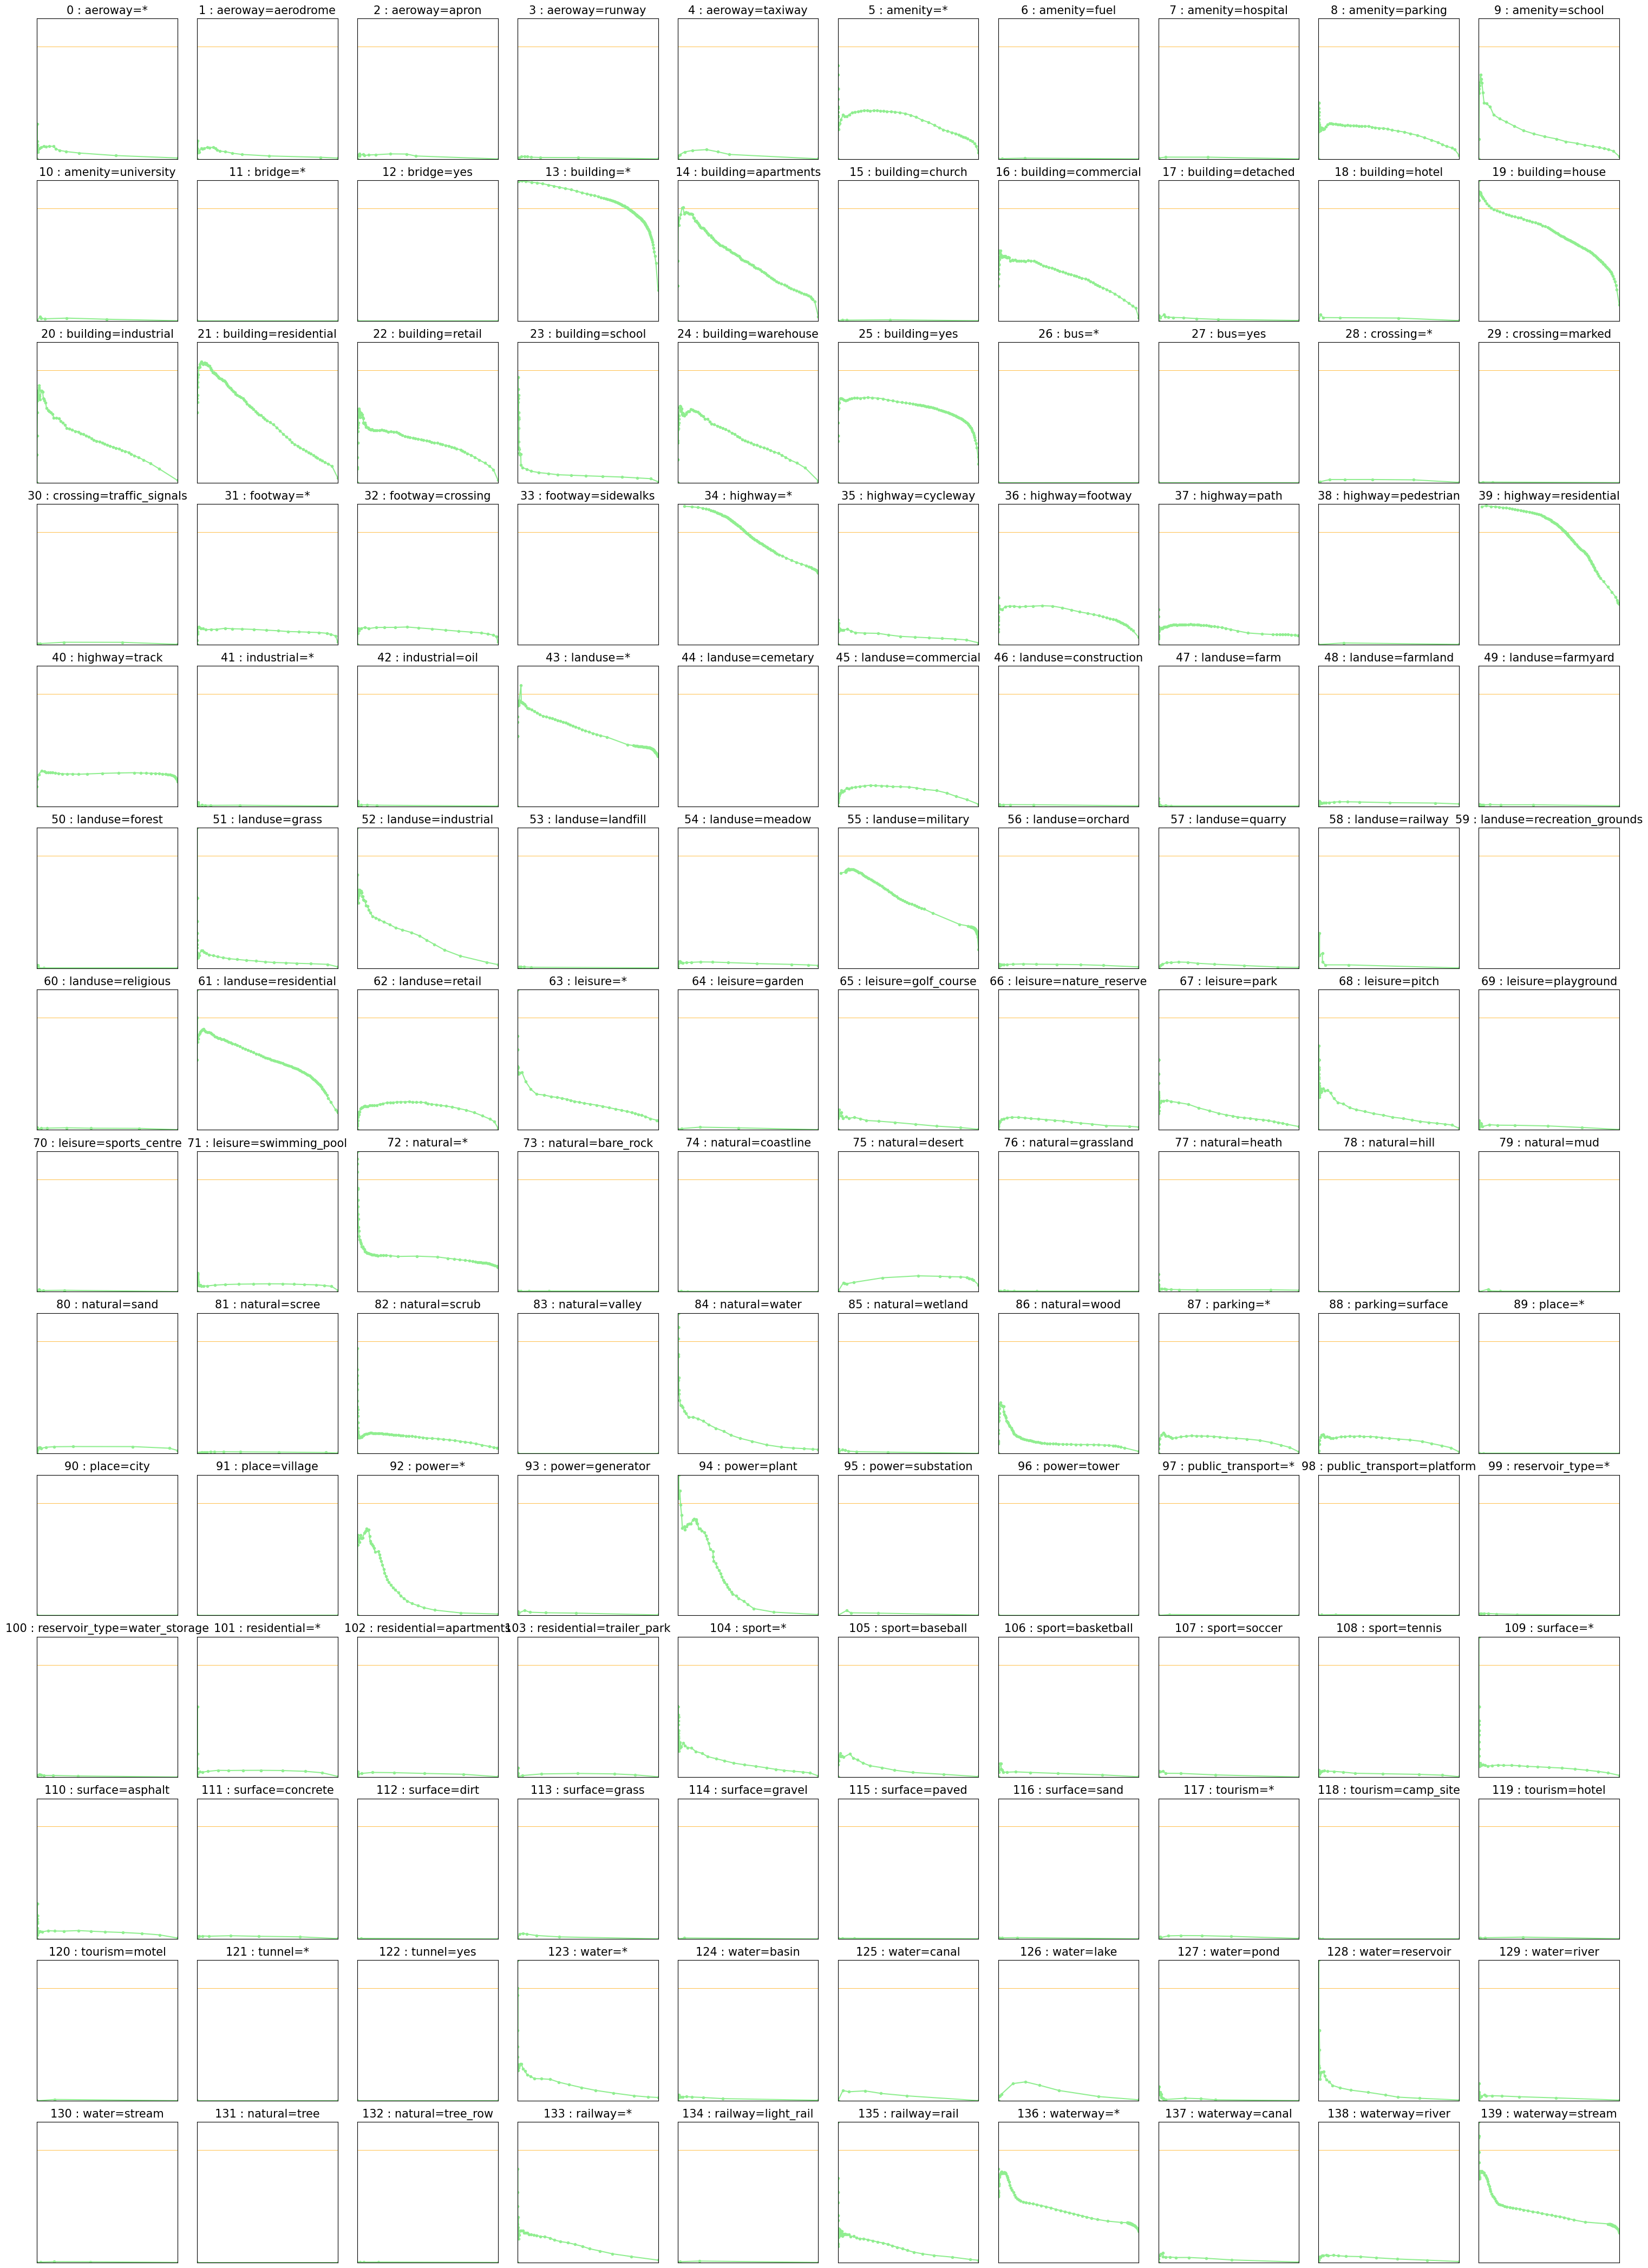

In [19]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(f"{c} : {name_dict[c]}", fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c in classes_retain:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='lightgreen');
    else:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='gray');
plt.tight_layout();